コンペまとめ
1. 目的
目的の確認:
医療費予測の分類
医療データを用いて、保険の費用帯を予測する

2. 結果
結果の概要:
 コンペの結果を簡潔にまとめます。

3. 問題点
問題点の特定:
    ①データが少なく、過学習が起こしやすいデータであった。
    ②アンサンブル学習をした方が過学習を引き起こし、スコアが低下した。
    ③Target-Encodingでは、結果がリークしてしまい、良い結果が得られなかった。
    ④Deep Learningを試したが、過学習を引き起こし、スコアが低下した。

4. 改善点
改善点の提案:
①Deep Learningでは過学習が引き起こさないようなハイパーパラメータの設定を模索できるよう取り組みたい。
②Target-Encodingでは、リークしてしまい、良い結果が得られなかったため、リークしないようデータを分割し、リークを防ぎたい。
③regionに対して良い特徴量の抽出する方法があったのではないか。

5. 学びと次への活用
学びの整理:

    ①データの少ないコンペに対する対処法を自身で導き出せた。
    モデル構築の際、過学習が散見されたため、モデル選定の際やハイパーパラメータの探索、設定を行う際は、過学習が起きないよう配慮した。

    ②コンペでは有用であるXGBoostやLightGBMにこだわらず、様々な手法でアプローチすることができた。その中で、ヒートマップの相関関係からそれぞれのデータが非共変性であると判断し、このような条件を得意とするRandomForestに目を付け、実装した。この仮説を導き出せたことは成長である。今回のデータコンペで使用したアプローチ手法は線形回帰、ロジステック回帰、決定木、SVM、KNN,XGBoost,LightGBM,CatBoostなどの手法を活用した。

    ③データの本質を理解できた。データコンペにおいて最も重要であるデータの前処理部分において、それぞれのデータの特徴を捉えることができた。具体的には、ＢＭＩの捉え方。データコンペ参加当初では、ＢＭＩが高いほど医療費が高額になり、低いほど、低額になるとかんがえてしまっていた。しかし、各カラムの中身、本質を考えた際、ＢＭＩが一定の値を下回ると逆に、健康リスクが発生することに気づけた。他にも、データカラムのＡｇｅでは分散が大きかったため、対数をとることによって、スコアの向上を見込めた。

    ④パラメータ設定手法
    今回はスコア向上のため、パラメータの設定に注力した。最初はGridsearchを採用して、計算を回していたが、ネット上では、ランダムサーチやベイズ最適化によるハイパーパラメータの設定が有用であることを知り、ベイズ最適化によって良いスコアを得ることができた。また、パラメータの設定項目に関しては、過学習が起こしやすい点を考慮して、設定した。



# **1　必要なモジュールを読み込む**

今回はRandomForestを採用し、コーディングを行う。



In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
!pip install category_encoders

import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score,roc_auc_score

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from category_encoders import TargetEncoder

!pip install catboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.2 MB/s eta 0:00:00


#2 データ読み込み、探索　および、データ準備

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_folder = '/content/drive/MyDrive/Date/SIGNATE/医療費予測'

#df_train = pd.read_csv(root_folder + '/train.csv')
#df_test = pd.read_csv(root_folder + '/test.csv')
#df_submit = pd.read_csv(root_folder + '/submit.csv', header=None)

df_train = pd.read_csv('/content/drive/MyDrive/IT/Signate/医療費予測/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/IT/Signate/医療費予測/test (3).csv')
df_submit = pd.read_csv('/content/drive/MyDrive/IT/Signate/医療費予測/sample_submit.csv', header=None)

In [ ]:
df_train = pd.concat([df_train, df_test])

In [ ]:
df_train.describe()

,id,age,bmi,children,charges
count,2000.000000,2000.0000,2000.000000,2000.000000,1600.000000
mean,999.500000,39.0340,32.473233,1.000000,0.306250
std,577.494589,13.4411,5.799794,1.251312,0.628656
min,0.000000,18.0000,20.627626,0.000000,0.000000
25%,499.750000,27.0000,28.645569,0.000000,0.000000
50%,999.500000,40.0000,32.273336,1.000000,0.000000
75%,1499.250000,50.0000,37.092529,2.000000,0.000000
max,1999.000000,64.0000,47.290644,5.000000,2.000000


describeによる表記によって、外れ値がないことの確認。
そして、Ageが取り得る値が広く、分散が大きいことを認識。
BMIに関しては、最小値が20.6と低すぎない値であることを確認した。

In [ ]:
df_train

,id,age,sex,bmi,children,smoker,region,charges
0,0,26,male,32.665465,3,no,southeast,0.0
1,1,41,male,29.798725,1,no,southwest,0.0
2,2,28,male,32.722029,0,yes,northwest,1.0
3,3,20,female,38.429831,2,no,southeast,0.0
4,4,45,female,29.641854,1,no,northwest,0.0
...,...,...,...,...,...,...,...,...
395,1968,47,female,24.915980,1,no,northwest,NaN
396,1972,18,female,44.752922,0,no,southeast,NaN
397,1979,33,female,37.203015,0,yes,southeast,NaN
398,1983,29,male,33.617369,1,no,northwest,NaN


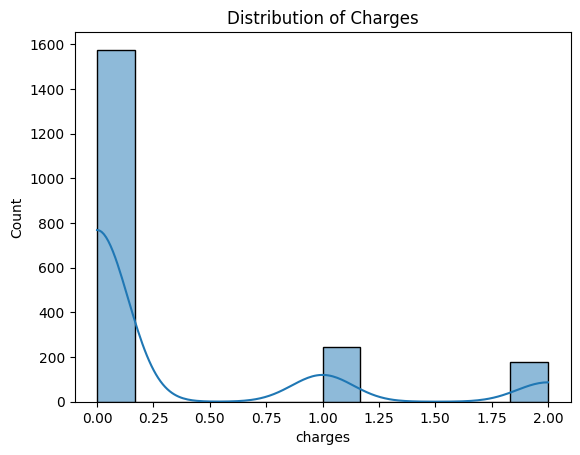

In [ ]:
#下記からデータの図示し、データの特徴を捉えていく
sns.histplot(data = df_train, x='charges',kde=True)
plt.title('Distribution of Charges')
plt.show()


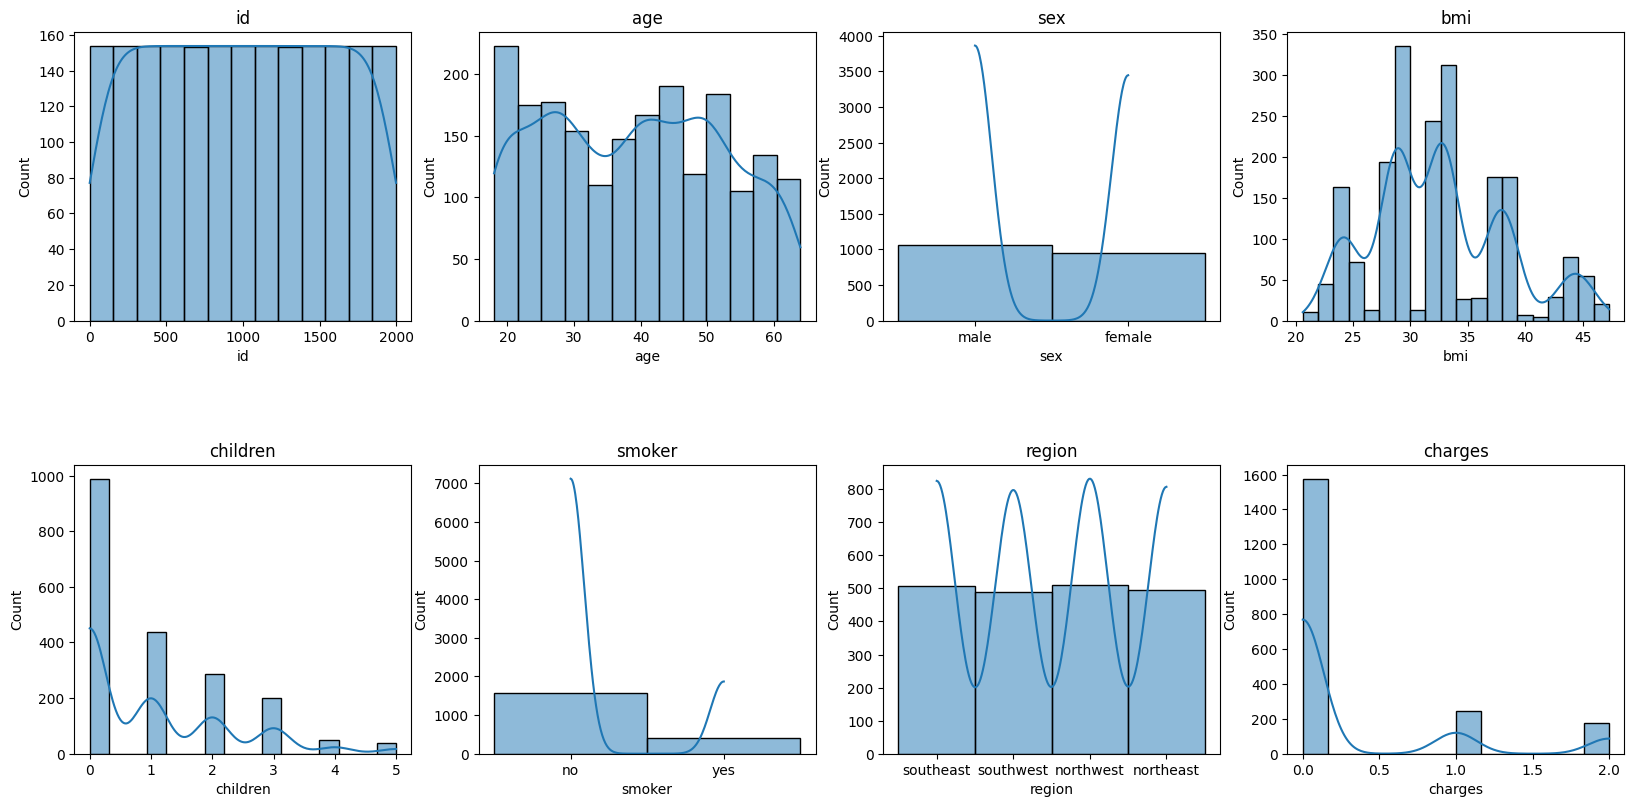

In [ ]:
#　各カラムのヒストグラムを作成

plt.figure(figsize=(20,15))
plt.subplots_adjust(hspace=0.5)

for i, col in enumerate(df_train.columns):
    plt.subplot(3, 4, i+1)
    sns.histplot(data=df_train, x=col, kde=True)
    plt.title(col)
plt.show()

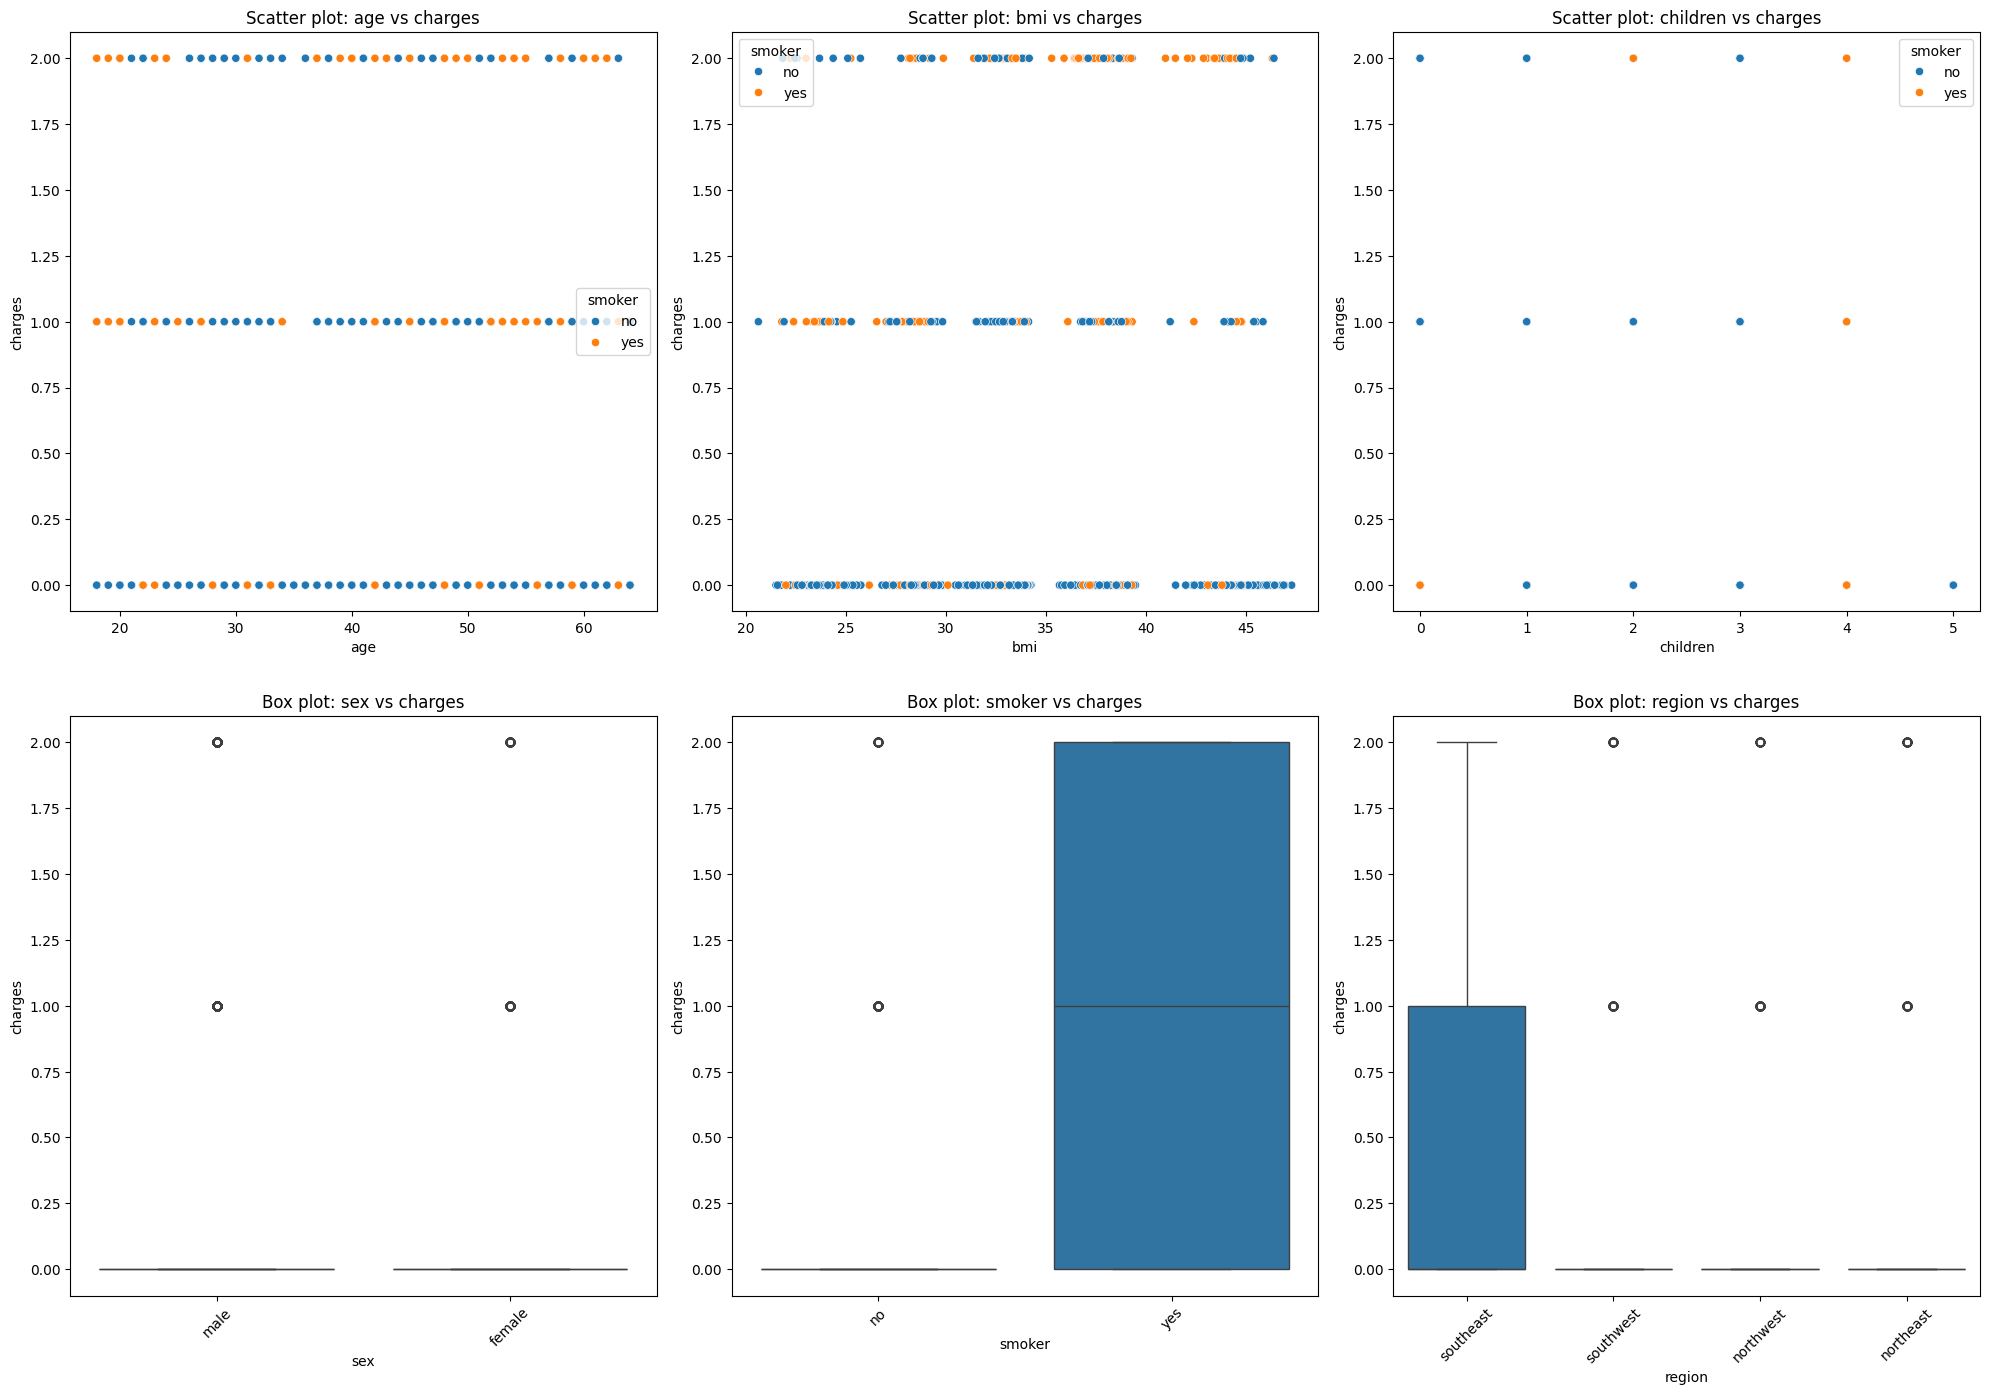

In [ ]:
#　以下からは目的変数chargesと各カラムとの関係性を捉えていくために散布図にまとめる
#　ただし、喫煙しているか否かが大きな影響を及ぼすため、図に表示させる

plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.5,wspace=0.3)

# 数値型カラムのリスト（'id'と'charges'を除く）
numeric_columns = df_train.select_dtypes(include=['int64', 'float64']).columns.drop(['id', 'charges'])

# カテゴリカル変数のリスト
categorical_columns = df_train.select_dtypes(include=['object']).columns

# 散布図と箱ひげ図の作成
plot_number = 1

# 数値型変数の散布図
for column in numeric_columns:
    plt.subplot(3, 3, plot_number)
    sns.scatterplot(x=column, y='charges', hue = 'smoker',data=df_train)
    plt.title(f'Scatter plot: {column} vs charges')
    plot_number += 1

# カテゴリカル変数の箱ひげ図
for column in categorical_columns:
    plt.subplot(3, 3, plot_number)
    sns.boxplot(x=column, y='charges', data=df_train)
    plt.title(f'Box plot: {column} vs charges')
    plt.xticks(rotation=45)
    plot_number += 1

plt.tight_layout()
plt.show()





In [ ]:
#　カテゴリー変数を変換する（すでに欠損値がないことを確認済）
df_train = pd.get_dummies(df_train, columns=['sex','smoker','region'] , dtype=int)

#　Age,bmiに対して対数変換を行い、スコアの向上を目指す
df_train['age'] = np.log(df_train['age'])
df_train['bmi'] = np.log(df_train['bmi'])

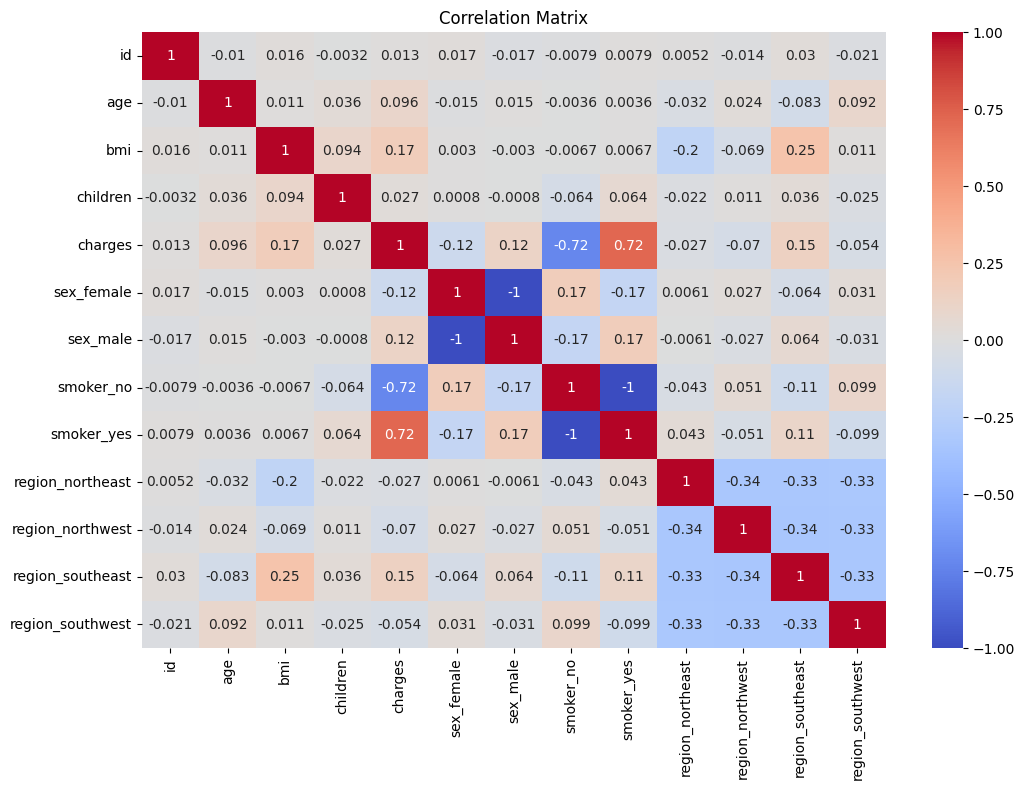

In [ ]:
#　ヒートマップを用いて、目的変数との相関係数を数値として捉えるとともに、説明変数同士の二重共線性がないかの確認。

plt.figure(figsize=(12,8))
corr = df_train.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
#　最後に、idのデータの内容と関係性がないため、カラム毎除去する。
df_train = df_train.drop(columns='id')

In [ ]:
#　df_train_とdf_testを元に戻す。df_testは予測するもとであるため、このタイミングで分ける。
df_train_ = df_train[df_train['charges'].notnull()]
df_test = df_train[df_train['charges'].isnull()]

#　df_train_を学習用と評価用で分ける
X = df_train_.drop(columns = ['charges'])
y = df_train_['charges']

### 3　モデル構築とハイパーパラメータの設定（ベイズ最適化）

In [ ]:
#RandomForestのベイズ最適化
!pip install optuna
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

def objective_rf(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 1500, 3000, 1),
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'random_state': 42
    }

    model = RandomForestClassifier(**param)
    scores = cross_val_score(model, X, y, cv=10, scoring='f1_macro')
    return scores.mean()

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=300)

print('RandomForest Best Score:', study_rf.best_value)
print('RandomForest Best Params:', study_rf.best_params)

In [ ]:

# 最適なハイパーパラメータを設定

rf_best_params =  {'n_estimators': 658, 'max_depth': 2, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': None}
 #{'n_estimators': 2730, 'max_depth': 11, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': None}
# {'n_estimators': 1720, 'max_depth': 15, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': None}
  #{'n_estimators': 658, 'max_depth': 2, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': None}

#  {'n_estimators': 294, 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': None}

# {'n_estimators': 3460, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': None}
 #{'n_estimators': 9400, 'max_depth': 21, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': None}
# {'n_estimators': 3850, 'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 7, 'max_features': None}


#rf_best_params = rf_grid.best_params_
rf_model = RandomForestClassifier(**rf_best_params)

# 全データでモデルを学習
rf_model.fit(X, y)

# 提出用データの読み込み
X_test = df_test.drop('charges', axis=1)  # 'charges'列を削除

# 提出用データに対する予測
y_pred = rf_model.predict(X_test)

### 提出用データを作成したが、今回は趣旨とはずれるため、記載せず。


# その他の分析アプローチ手法のまとめ

### グリッドサーチによるハイパーパラメータの設定

In [ ]:
# データの分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=43)

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# F1スコアを評価指標に設定
f1_scorer = make_scorer(f1_score, average='macro')

rf_params = {'n_estimators': [100, 300, 500],
             'max_depth': [3, 5, 7, 10],
             'min_samples_leaf': [1, 5, 10],
             'max_features': ['sqrt', 'log2'],
             'min_samples_split': [2, 5, 10]}


# K分割交差検証の設定
kfold = KFold(n_splits=15, shuffle=True, random_state=42)

# グリッドサーチ (K分割交差検証を適用)
rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=kfold, n_jobs=-1, scoring=f1_scorer)
xgb_grid = GridSearchCV(XGBClassifier(), xgb_params, cv=kfold, n_jobs=-1, scoring=f1_scorer)
lgbm_grid = GridSearchCV(LGBMClassifier(), lgbm_params, cv=kfold, n_jobs=-1, scoring=f1_scorer)
cat_grid = GridSearchCV(CatBoostClassifier(verbose=0), cat_params, cv=kfold, n_jobs=-1, scoring=f1_scorer)

# モデル学習
rf_grid.fit(X, y)
xgb_grid.fit(X, y)
lgbm_grid.fit(X, y)
cat_grid.fit(X, y)


# 最適ハイパーパラメータ
print('Random Forest best params:', rf_grid.best_params_)
print('XGBoost best params:', xgb_grid.best_params_)
print('LightGBM best params:', lgbm_grid.best_params_)
print('CatBoost best params:', cat_grid.best_params_)

# 検証データでの評価
rf_pred = rf_grid.best_estimator_.predict(X_val)
xgb_pred = xgb_grid.best_estimator_.predict(X_val)
lgbm_pred = lgbm_grid.best_estimator_.predict(X_val)
cat_pred = cat_grid.best_estimator_.predict(X_val)

print('Random Forest Metrics (Validation):')
print(f'Accuracy: {accuracy_score(y_val, rf_pred):.3f}')
print(f'Precision: {precision_score(y_val, rf_pred, average="macro"):.3f}')
print(f'Recall: {recall_score(y_val, rf_pred, average="macro"):.3f}')
print(f'F1-score: {f1_score(y_val, rf_pred, average="macro"):.3f}')

# XGBoost, LightGBM, CatBoostの評価指標も同様に出力
print('XGBoost Metrics (Validation):')
print(f'Accuracy: {accuracy_score(y_val, xgb_pred):.3f}')
print(f'Precision: {precision_score(y_val, xgb_pred, average="macro"):.3f}')
print(f'Recall: {recall_score(y_val, xgb_pred, average="macro"):.3f}')
print(f'F1-score: {f1_score(y_val, xgb_pred, average="macro"):.3f}')

print('LightGBM Metrics (Validation):')
print(f'Accuracy: {accuracy_score(y_val, lgbm_pred):.3f}')
print(f'Precision: {precision_score(y_val, lgbm_pred, average="macro"):.3f}')
print(f'Recall: {recall_score(y_val, lgbm_pred, average="macro"):.3f}')
print(f'F1-score: {f1_score(y_val, lgbm_pred, average="macro"):.3f}')

print('CatBoost Metrics (Validation):')
print(f'Accuracy: {accuracy_score(y_val, cat_pred):.3f}')
print(f'Precision: {precision_score(y_val, cat_pred, average="macro"):.3f}')
print(f'Recall: {recall_score(y_val, cat_pred, average="macro"):.3f}')
print(f'F1-score: {f1_score(y_val, cat_pred, average="macro"):.3f}')

# テストデータでの評価
rf_pred = rf_grid.best_estimator_.predict(X_test)
xgb_pred = xgb_grid.best_estimator_.predict(X_test)
lgbm_pred = lgbm_grid.best_estimator_.predict(X_test)
cat_pred = cat_grid.best_estimator_.predict(X_test)

print('Random Forest Metrics (Test):')
print(f'Accuracy: {accuracy_score(y_test, rf_pred):.3f}')
print(f'Precision: {precision_score(y_test, rf_pred, average="macro"):.3f}')
print(f'Recall: {recall_score(y_test, rf_pred, average="macro"):.3f}')
print(f'F1-score: {f1_score(y_test, rf_pred, average="macro"):.3f}')

# XGBoost, LightGBM, CatBoostの評価指標も同様に出力
print('XGBoost Metrics (Test):')
print(f'Accuracy: {accuracy_score(y_test, xgb_pred):.3f}')
print(f'Precision: {precision_score(y_test, xgb_pred, average="macro"):.3f}')
print(f'Recall: {recall_score(y_test, xgb_pred, average="macro"):.3f}')
print(f'F1-score: {f1_score(y_test, xgb_pred, average="macro"):.3f}')

print('LightGBM Metrics (Test):')
print(f'Accuracy: {accuracy_score(y_test, lgbm_pred):.3f}')
print(f'Precision: {precision_score(y_test, lgbm_pred, average="macro"):.3f}')
print(f'Recall: {recall_score(y_test, lgbm_pred, average="macro"):.3f}')
print(f'F1-score: {f1_score(y_test, lgbm_pred, average="macro"):.3f}')

print('CatBoost Metrics (Test):')
print(f'Accuracy: {accuracy_score(y_test, cat_pred):.3f}')
print(f'Precision: {precision_score(y_test,cat_pred, average="macro"):.3f}')
print(f'Recall: {recall_score(y_test, cat_pred, average="macro"):.3f}')
print(f'F1-score: {f1_score(y_test, cat_pred, average="macro"):.3f}')


### ベイズ最適化～XGBoost,LightGBM～

In [ ]:
#ベイズ最適化をoputnaを使って、ベイズ最適化を行う

!pip install optuna
import optuna
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

def objective(trial):
    # ハイパーパラメータの範囲を設定
    max_depth = trial.suggest_int('max_depth', 2, 10)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    gamma = trial.suggest_float('gamma', 0, 1)
    subsample = trial.suggest_float('subsample', 0.5, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1)
    eta = trial.suggest_float('eta', 0.01, 0.3)

    # XGBoostモデルを構築
    model = xgb.XGBClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        eta=eta,
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42
    )

    # 交差検証でスコアを計算
    scores = cross_val_score(model, X, y, cv=10, scoring='f1_macro')
    mean_score = scores.mean()

    return mean_score

# Optunaの実行
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

# 最適なハイパーパラメータを取得
print(study.best_params)

In [ ]:
#LightGBMのベイズ最適化
!pip install optuna
import optuna
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

def objective_lgbm(trial):
    param = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 3, # 多クラス分類の場合は指定が必要
        'metric': 'multi_logloss',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_bin': trial.suggest_int('max_bin', 200, 500),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-9, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-9, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'random_state': 42
    }

    model = lgb.LGBMClassifier(**param)
    scores = cross_val_score(model, X, y, cv=10, scoring='f1_macro')
    return scores.mean()

study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=300)

print('LightGBM Best Score:', study_lgbm.best_value)
print('LightGBM Best Params:', study_lgbm.best_params)

### アンサンブル学習

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [
              ('rf', rf_grid.best_estimator_),
              ('xgb', xgb_grid.best_estimator_),
              ('lgbm', lgbm_grid.best_estimator_),
              ('cat', cat_grid.best_estimator_)
]
#アンサンブル学習の最後のモデルを変更することにより精度によって変化があるか確認

#ロジステック回帰
#stack_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

#決定木
#from sklearn.ensemble import RandomForestClassifier
#stack_model = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier())

#グラディエントブースト
#from xgboost import XGBClassifier
#stack_model = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier())

#他にも
#サポートベクターマシン (Support Vector Machine)
#from sklearn.svm import SVC
#stack_model = StackingClassifier(estimators=estimators, final_estimator=SVC())
#ニューラルネットワーク (Neural Network)
from sklearn.neural_network import MLPClassifier
stack_model = StackingClassifier(estimators=estimators, final_estimator=MLPClassifier())

stack_model.fit(X_train, y_train)
stack_pred = stack_model.predict(X_test)

In [ ]:
print(f'Stacking Accuracy: {accuracy_score(y_test, stack_pred):.3f}')
print(f'Stacking Precision: {precision_score(y_test, stack_pred, average="macro"):.3f}')
print(f'Stacking Recall: {recall_score(y_test, stack_pred, average="macro"):.3f}')
print(f'Stacking F1-score: {f1_score(y_test, stack_pred, average="macro"):.3f}')

### Target-Encodingの導入

In [ ]:
#TargetEncoder を初期化
target_cols = ['region', 'sex', 'children', 'smoker']
target_encoder = TargetEncoder(cols=target_cols)

# Target Encoding を実行
data_encoded = target_encoder.fit_transform(df_train[target_cols], df_train['charges'])

# 元のデータフレームに新しい列を追加
#df_train = df_train.join(data_encoded)
df_train = df_train.join(data_encoded, rsuffix='_encoded')


# 重複する列を削除 (元のカテゴリ変数の列を削除)
df_train = df_train.drop(columns=target_cols)
df_train = df_train.drop_duplicates(subset='id')
# 結果を確認
df_train = df_train.iloc[:,:8]
df_train

### Neural Network手法

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np

# データの準備（X, yは既に準備されているものとします）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# データの標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# テンソルへの変換
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# ハイパーパラメータ
input_size = X_train.shape[1]
hidden_size = 128
output_size = 3  # 0, 1, 2の3クラス
num_epochs = 200
batch_size = 32
learning_rate = 0.001

# モデル定義（前回と同じ）
class DeepClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# モデル、損失関数、オプティマイザの初期化
model = DeepClassifier(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# データローダーの作成
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 訓練ループ
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # 評価
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        _, predicted = torch.max(y_pred, 1)

        # F1マクロスコアの計算
        f1_macro = f1_score(y_test_tensor.numpy(), predicted.numpy(), average='macro')

        test_loss = criterion(y_pred, y_test_tensor)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {running_loss/len(train_loader):.4f}, '
          f'Test Loss: {test_loss:.4f}, '
          f'F1 Macro: {f1_macro:.4f}')

    scheduler.step()

# 最終評価
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    _, predicted = torch.max(y_pred, 1)

    # 最終的なF1マクロスコアの計算
    final_f1_macro = f1_score(y_test_tensor.numpy(), predicted.numpy(), average='macro')
    final_loss = criterion(y_pred, y_test_tensor)
    print(f'Final Test Loss: {final_loss:.4f}, Final F1 Macro: {final_f1_macro:.4f}')